In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Modifying the path so we can import from src directory.
import sys
import os
sys.path.append(os.path.abspath('..'))

from collections import Counter, defaultdict
from itertools import chain
import copy
import pickle
import random
import time

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from pyvis.network import Network

from src.example_graphs import simple_undirected_graph, simple_directed_graph
from src.UndirectedGraph import UndirectedGraph
from src.DirectedGraph import DirectedGraph
from src.DataLoader import DataLoader
from src.GraphCreator import GraphCreator, NetworkXGraphCreator
from src.RandomWalk import RandomWalk

from src.io_helpers import pickle_obj, load_pickled_obj
from src.networkx_helpers import combine_graphs
from src.networkx_multigraph_helpers import (get_edge_attrs, aggregate_numeric_properties,
                                             sum_numeric_properties, count_edges)
from src.os_helpers import getsize

In [14]:
ROOT_DIRECTORY = os.path.split(os.getcwd())[0]
DATA_DIRECTORY = os.path.join(ROOT_DIRECTORY, 'data')
PICKLED_DATA_DIRECTORY = os.path.join(ROOT_DIRECTORY, 'data_pickle')

## Load our data

In [40]:
G_weighted = load_pickled_obj(os.path.join(PICKLED_DATA_DIRECTORY, 'networkx_weighted_full.pickle'))
G_combined = load_pickled_obj(os.path.join(PICKLED_DATA_DIRECTORY, 'networkx_multigraph_combined.pickle'))

# If you Went on a Random Walk...Where Would You End Up?
https://stackoverflow.com/questions/37311651/get-node-list-from-random-walk-in-networkx (A resource that I haven't read yet. You can probably do this using matrix multiplication.)

## Let's start with a subset of the graph again

In [16]:
G_weighted_subset = G_weighted.edge_subgraph(G_weighted.edges('vegan'))

## Increasing Efficiency of RandomWalk class
Our RandomWalk walk was slowing down significantly, and I discovered that it was because we were storing a full copy of the graph inside of every instance of the RandomWalk class. With the graph size we were dealing with, this added up very quickly and probably locked down all the computer's memory.

In [17]:
walk1 = RandomWalk(G_weighted)

In [18]:
for i in range(100):
    walk1.walk()
    if walk1.blocked:
        break

In [19]:
print(walk1.steps_taken)
print(Counter(walk1.nodes_seen).most_common())

2
[('betterfap', 1), ('nsfw_gif', 1), ('twohanders', 1)]


In [20]:
print(getsize(walk1))

196401647


In [21]:
walk1.delete_graph()

In [22]:
getsize(walk1)

970

In [23]:
walk2 = RandomWalk(G_weighted)
for i in range(100):
    walk2.walk()
    if walk2.blocked:
        break

In [24]:
print(walk2.steps_taken)
print(Counter(walk2.nodes_seen).most_common())

0
[('tonkamemes', 1)]


In [25]:
getsize(walk2)

196401715

In [26]:
walk2.delete_graph()

In [27]:
getsize(walk2)

711

In [28]:
random_walks = [walk1, walk2]

In [29]:
getsize(random_walks)

1697

## Go on the walks! You can change the i-range here (number of trials) and j-range (max length of the walk before we shut it down)

In [30]:
for i in range(10000):
    walk = RandomWalk(G_weighted)
    if i % 100 == 0:
        print(i)
    for j in range(1000):
        walk.walk()
        if walk.blocked:
            break
    walk.delete_graph()
    random_walks.append(copy.deepcopy(walk))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


## Graphing the distribution of steps taken

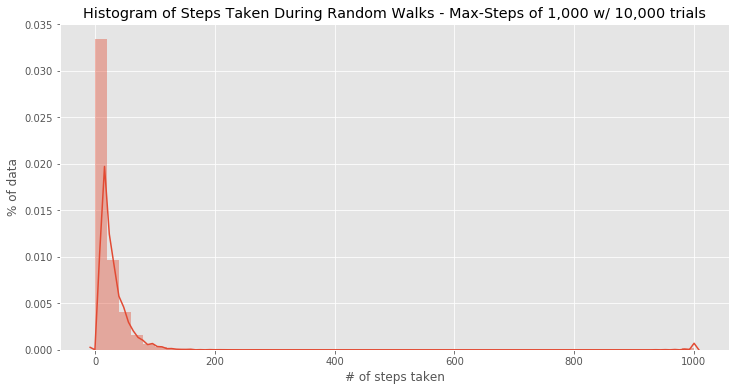

In [31]:
# This trial had max of 1000 steps per walk, and 10,000 trials.
step_counts = [walk.steps_taken for walk in random_walks]
fig = plt.figure(figsize=(12, 6))
ax = sns.distplot(step_counts)
_ = ax.set_title("Histogram of Steps Taken During Random Walks - Max-Steps of 1,000 w/ 10,000 trials")
_ = ax.set_ylabel("% of data")
_ = ax.set_xlabel("# of steps taken")

In [32]:
# These are the step counts from a previous trial.
# Max of 100 steps per walk, with 1000 trials.
step_counts_100_1000 = [17, 29, 1, 6, 8, 15, 14, 6, 0, 55, 4, 18, 9, 77, 33, 27, 0, 19, 41, 31, 6, 23, 25, 14, 2, 0, 34, 22, 11, 24, 21, 0, 94, 25, 28, 22, 11, 61, 0, 44, 0, 11, 40, 9, 20, 1, 43, 18, 6, 35, 0, 39, 1, 40, 16, 4, 5, 28, 14, 100, 17, 2, 5, 12, 15, 37, 34, 12, 23, 31, 0, 0, 61, 34, 21, 0, 18, 17, 4, 41, 25, 0, 48, 33, 0, 28, 9, 3, 5, 2, 0, 12, 47, 33, 41, 21, 20, 0, 15, 0, 2, 2, 5, 2, 41, 7, 20, 44, 10, 10, 35, 16, 42, 17, 1, 19, 0, 3, 54, 0, 2, 22, 9, 0, 24, 10, 40, 13, 40, 17, 24, 29, 0, 0, 27, 21, 16, 7, 7, 1, 20, 0, 1, 3, 0, 42, 16, 1, 43, 12, 2, 0, 10, 27, 0, 2, 0, 1, 65, 0, 3, 6, 1, 3, 19, 19, 12, 3, 3, 8, 7, 4, 7, 24, 1, 40, 0, 3, 6, 1, 26, 2, 56, 8, 5, 15, 100, 16, 33, 10, 11, 34, 3, 2, 1, 19, 22, 0, 2, 37, 1, 0, 21, 12, 0, 1, 15, 0, 0, 0, 0, 53, 13, 100, 9, 13, 40, 46, 17, 13, 2, 29, 16, 4, 1, 22, 26, 6, 26, 13, 3, 2, 41, 0, 27, 4, 16, 0, 33, 11, 26, 40, 43, 6, 42, 2, 2, 19, 8, 11, 14, 0, 0, 0, 11, 11, 0, 13, 22, 0, 12, 10, 7, 1, 18, 0, 2, 1, 7, 22, 2, 61, 39, 6, 45, 5, 5, 0, 7, 9, 23, 9, 4, 4, 25, 69, 0, 1, 14, 4, 5, 4, 4, 0, 22, 13, 0, 45, 9, 22, 1, 13, 68, 1, 6, 20, 0, 12, 24, 0, 30, 2, 18, 1, 7, 57, 0, 10, 15, 0, 7, 27, 8, 0, 20, 5, 5, 6, 10, 21, 16, 13, 12, 21, 1, 0, 2, 6, 25, 10, 8, 19, 0, 83, 28, 13, 5, 0, 3, 0, 40, 27, 63, 1, 11, 8, 22, 23, 1, 4, 2, 0, 0, 19, 1, 3, 24, 19, 0, 10, 9, 10, 5, 3, 18, 16, 1, 0, 22, 0, 74, 8, 21, 45, 40, 0, 55, 16, 28, 6, 62, 10, 12, 9, 4, 6, 6, 0, 15, 15, 0, 39, 1, 100, 43, 10, 36, 0, 18, 12, 3, 27, 57, 3, 0, 4, 2, 28, 24, 49, 2, 0, 15, 19, 34, 7, 0, 10, 40, 8, 20, 1, 19, 19, 17, 0, 57, 8, 19, 22, 30, 0, 10, 2, 2, 7, 5, 26, 6, 58, 23, 3, 16, 0, 3, 46, 3, 40, 3, 6, 31, 33, 52, 4, 5, 13, 0, 20, 5, 13, 22, 23, 0, 46, 73, 28, 1, 53, 10, 11, 10, 12, 13, 100, 21, 61, 0, 0, 0, 0, 8, 24, 1, 15, 16, 22, 6, 14, 8, 6, 3, 44, 15, 7, 25, 0, 9, 5, 0, 7, 15, 3, 22, 6, 16, 36, 6, 26, 12, 55, 0, 29, 5, 23, 2, 4, 8, 51, 84, 31, 1, 21, 17, 60, 52, 46, 5, 10, 0, 62, 24, 38, 13, 100, 4, 53, 16, 33, 9, 10, 29, 0, 3, 24, 64, 10, 4, 18, 6, 0, 11, 0, 46, 4, 36, 0, 3, 2, 6, 17, 3, 0, 23, 5, 3, 0, 25, 61, 9, 19, 8, 1, 17, 24, 1, 0, 10, 0, 0, 30, 45, 12, 2, 38, 15, 0, 0, 18, 46, 0, 0, 27, 32, 35, 9, 0, 11, 46, 6, 79, 5, 3, 59, 17, 73, 19, 2, 25, 13, 47, 4, 21, 20, 0, 14, 4, 100, 75, 0, 0, 63, 89, 25, 12, 15, 22, 15, 2, 14, 0, 55, 40, 42, 1, 64, 3, 0, 13, 38, 5, 0, 4, 0, 1, 0, 3, 3, 0, 10, 0, 22, 39, 7, 9, 6, 79, 7, 16, 9, 0, 7, 54, 0, 6, 3, 15, 17, 37, 10, 1, 12, 45, 100, 0, 34, 6, 7, 13, 28, 0, 19, 65, 59, 0, 2, 28, 35, 18, 45, 26, 2, 1, 2, 15, 7, 6, 10, 3, 17, 0, 45, 0, 16, 1, 21, 49, 77, 13, 27, 25, 11, 0, 42, 0, 9, 0, 1, 0, 60, 4, 61, 19, 17, 6, 9, 23, 5, 0, 2, 100, 29, 5, 0, 2, 13, 14, 31, 44, 12, 24, 12, 66, 51, 10, 68, 7, 2, 1, 9, 9, 55, 9, 17, 9, 0, 7, 3, 15, 13, 5, 12, 0, 0, 12, 0, 26, 2, 2, 0, 0, 21, 4, 0, 12, 97, 5, 58, 0, 1, 37, 21, 39, 28, 43, 42, 13, 0, 5, 6, 63, 0, 26, 0, 7, 10, 0, 17, 23, 13, 1, 19, 0, 23, 22, 2, 2, 3, 11, 13, 8, 33, 38, 1, 22, 12, 42, 0, 11, 0, 0, 7, 0, 12, 1, 0, 1, 10, 84, 43, 12, 9, 14, 95, 14, 30, 4, 43, 3, 24, 16, 15, 0, 7, 6, 10, 25, 2, 71, 6, 1, 13, 59, 7, 50, 51, 32, 0, 0, 17, 1, 0, 1, 30, 3, 1, 34, 8, 24, 31, 46, 0, 23, 33, 1, 1, 3, 52, 9, 2, 43, 21, 32, 4, 51, 2, 22, 53, 11, 18, 59, 48, 24, 10, 2, 22, 23, 8, 23, 7, 55, 0, 4, 36, 16, 11, 29, 0, 12, 41, 14, 34, 48, 5, 63, 27, 0, 2, 16, 0, 100, 1, 1, 11, 0, 0, 26, 57, 0, 6, 68, 0, 21, 0, 0, 20, 89, 4, 5, 44, 24, 4, 3, 4, 0, 6, 13, 100, 0, 0, 8, 9, 0, 45, 2, 19, 2, 41, 95, 17, 81, 13, 0, 18, 29, 12, 3, 13, 72, 0, 8, 13, 3, 1, 56, 87, 12, 37, 4, 15, 44, 28, 0, 14, 0, 19, 1, 18, 29, 0, 29, 40, 8]

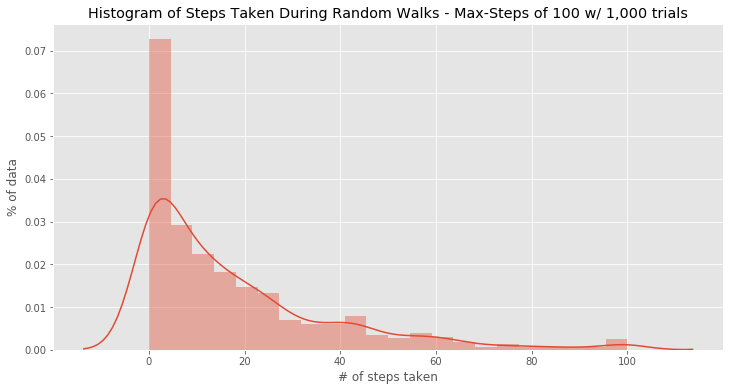

In [33]:
fig = plt.figure(figsize=(12, 6))
ax = sns.distplot(step_counts_100_1000)
_ = ax.set_title("Histogram of Steps Taken During Random Walks - Max-Steps of 100 w/ 1,000 trials")
_ = ax.set_ylabel("% of data")
_ = ax.set_xlabel("# of steps taken")

## What were the most common nodes seen?

In [34]:
for k, v in random_walks[0].nodes_seen.items():
    print(k, v)

betterfap 1
nsfw_gif 1
twohanders 1


In [35]:
all_nodes_seen = defaultdict(int)
for walk in random_walks:
    for node, seen_count in walk.nodes_seen.items():
        all_nodes_seen[node] += seen_count

In [36]:
len(all_nodes_seen)

23188

In [37]:
all_nodes_seen_counter = Counter(all_nodes_seen)

### Most common nodes seen on walks...

In [38]:
all_nodes_seen_counter.most_common()[:50]

[('askreddit', 4604),
 ('iama', 3904),
 ('pics', 2508),
 ('judgedvideogames', 2495),
 ('allgamersunited', 2493),
 ('videos', 2198),
 ('funny', 2179),
 ('beachboys', 1953),
 ('thebeachboys', 1951),
 ('todayilearned', 1584),
 ('hazardops', 1483),
 ('zmr', 1482),
 ('battlefleetgothic', 1476),
 ('bfgarmada', 1476),
 ('worldnews', 1416),
 ('gaming', 1382),
 ('science', 1106),
 ('news', 1102),
 ('gifs', 1032),
 ('books', 1012),
 ('reenactors', 1002),
 ('hadosacademy', 1001),
 ('cwreenactors', 1000),
 ('herorp', 1000),
 ('nostalriusauction', 999),
 ('kronosauction', 998),
 ('pensacolabeer', 995),
 ('emeraldcoastbeer', 994),
 ('bothell', 990),
 ('lynnwoodwa', 990),
 ('mpos', 988),
 ('modelwestdistrict', 988),
 ('colosseumtournament', 982),
 ('apotheosisvillage', 981),
 ('girlsinyogapants', 951),
 ('yogapants', 949),
 ('demohoi4', 943),
 ('demohoi4legislature', 943),
 ('politics', 873),
 ('wtf', 869),
 ('adviceanimals', 851),
 ('showerthoughts', 810),
 ('leagueoflegends', 798),
 ('music', 772),

### In contrast, the most common nodes in the dataset by degree...

In [41]:
Counter(dict(G_combined.degree)).most_common()[:50]

[('subredditdrama', 26625),
 ('askreddit', 25633),
 ('bestof', 22489),
 ('iama', 12808),
 ('pics', 11981),
 ('todayilearned', 11586),
 ('funny', 11142),
 ('videos', 9557),
 ('titlegore', 9534),
 ('worldnews', 9201),
 ('shitredditsays', 8250),
 ('news', 7473),
 ('gaming', 7403),
 ('shitpost', 6875),
 ('drama', 6638),
 ('writingprompts', 6416),
 ('the_donald', 6338),
 ('circlebroke2', 6302),
 ('conspiracy', 6296),
 ('politics', 6039),
 ('switcharoo', 6002),
 ('shitamericanssay', 5852),
 ('wtf', 5499),
 ('adviceanimals', 5244),
 ('bitcoin', 5178),
 ('gifs', 5057),
 ('leagueoflegends', 4948),
 ('explainlikeimfive', 4545),
 ('shitstatistssay', 4480),
 ('showerthoughts', 4462),
 ('science', 4380),
 ('pcmasterrace', 4327),
 ('hailcorporate', 4263),
 ('movies', 4061),
 ('soccer', 3917),
 ('nfl', 3682),
 ('technology', 3663),
 ('outoftheloop', 3596),
 ('fitnesscirclejerk', 3447),
 ('mildlyinteresting', 3412),
 ('dogecoin', 3376),
 ('anarcho_capitalism', 3304),
 ('tifu', 3264),
 ('sandersforpres

### And the most common nodes in the graph by in-degree...

In [42]:
Counter(dict(G_combined.in_degree)).most_common()[:50]

[('askreddit', 24295),
 ('pics', 11728),
 ('iama', 11624),
 ('todayilearned', 10292),
 ('funny', 10201),
 ('videos', 9216),
 ('worldnews', 8901),
 ('news', 7005),
 ('gaming', 5584),
 ('politics', 5511),
 ('adviceanimals', 5193),
 ('wtf', 5096),
 ('gifs', 5012),
 ('writingprompts', 4709),
 ('science', 4233),
 ('the_donald', 4014),
 ('showerthoughts', 3990),
 ('leagueoflegends', 3883),
 ('explainlikeimfive', 3556),
 ('movies', 3550),
 ('conspiracy', 3549),
 ('bitcoin', 3507),
 ('pcmasterrace', 3303),
 ('technology', 3210),
 ('mildlyinteresting', 3206),
 ('subredditdrama', 3167),
 ('soccer', 3160),
 ('tifu', 3020),
 ('nfl', 2869),
 ('aww', 2814),
 ('relationships', 2486),
 ('sandersforpresident', 2417),
 ('hockey', 2374),
 ('nba', 2371),
 ('europe', 2317),
 ('dota2', 2169),
 ('atheism', 2138),
 ('legaladvice', 2118),
 ('android', 2095),
 ('music', 2087),
 ('books', 2073),
 ('askhistorians', 2044),
 ('jokes', 2000),
 ('twoxchromosomes', 1980),
 ('kotakuinaction', 1967),
 ('dogecoin', 1921)

In [43]:
top_50_seen_in_walks = dict(all_nodes_seen_counter.most_common()[:50])
top_50_seen_in_walks_set = set(x for x in top_50_seen_in_walks)

top_50_by_degree = dict(Counter(dict(G_combined.degree)).most_common()[:50])
top_50_by_degree_set = set(x for x in top_50_by_degree)

top_50_by_in_degree = dict(Counter(dict(G_combined.in_degree)).most_common()[:50])
top_50_by_in_degree_set = set(x for x in top_50_by_in_degree)

## Seen in random walks, but not in the top number as far as in-degree

In [44]:
walks_but_not_in_degree = sorted([(x, top_50_seen_in_walks[x]) for x in top_50_seen_in_walks_set - top_50_by_in_degree_set], key=lambda x: x[1], reverse=True)
walks_but_not_in_degree

[('judgedvideogames', 2495),
 ('allgamersunited', 2493),
 ('beachboys', 1953),
 ('thebeachboys', 1951),
 ('hazardops', 1483),
 ('zmr', 1482),
 ('battlefleetgothic', 1476),
 ('bfgarmada', 1476),
 ('reenactors', 1002),
 ('hadosacademy', 1001),
 ('herorp', 1000),
 ('cwreenactors', 1000),
 ('nostalriusauction', 999),
 ('kronosauction', 998),
 ('pensacolabeer', 995),
 ('emeraldcoastbeer', 994),
 ('bothell', 990),
 ('lynnwoodwa', 990),
 ('mpos', 988),
 ('modelwestdistrict', 988),
 ('colosseumtournament', 982),
 ('apotheosisvillage', 981),
 ('girlsinyogapants', 951),
 ('yogapants', 949),
 ('demohoi4', 943),
 ('demohoi4legislature', 943)]

## Seen in top in-degree, but not seen as much in random walks

In [45]:
in_degree_but_not_walks = sorted([(x, top_50_by_in_degree[x]) for x in top_50_by_in_degree_set - top_50_seen_in_walks_set], key=lambda x: x[1], reverse=True)
in_degree_but_not_walks

[('writingprompts', 4709),
 ('explainlikeimfive', 3556),
 ('conspiracy', 3549),
 ('subredditdrama', 3167),
 ('soccer', 3160),
 ('tifu', 3020),
 ('nfl', 2869),
 ('aww', 2814),
 ('relationships', 2486),
 ('sandersforpresident', 2417),
 ('hockey', 2374),
 ('nba', 2371),
 ('europe', 2317),
 ('dota2', 2169),
 ('atheism', 2138),
 ('legaladvice', 2118),
 ('android', 2095),
 ('askhistorians', 2044),
 ('jokes', 2000),
 ('twoxchromosomes', 1980),
 ('kotakuinaction', 1967),
 ('dogecoin', 1921),
 ('games', 1891),
 ('globaloffensive', 1844),
 ('dataisbeautiful', 1835),
 ('futurology', 1833)]

# Why would we see something in a walk if it doesn't have one of the highest in-degrees?
Let's try to compare the nodes that were seen in walks but weren't in the top in-degree, vs the ones that were in the top in-degree but weren't seen in walks...

In [46]:
degree_centrality = nx.centrality.degree_centrality(G_combined)

In [47]:
walks_not_degree_centrality = [degree_centrality[node[0]] for node in walks_but_not_in_degree]
walks_not_degree_centrality

[0.00011908483305794966,
 2.9771208264487416e-05,
 4.4656812396731125e-05,
 2.9771208264487416e-05,
 4.4656812396731125e-05,
 7.442802066121854e-05,
 0.00010419922892570596,
 7.442802066121854e-05,
 2.9771208264487416e-05,
 2.9771208264487416e-05,
 4.4656812396731125e-05,
 2.9771208264487416e-05,
 5.954241652897483e-05,
 0.00011908483305794966,
 5.954241652897483e-05,
 2.9771208264487416e-05,
 5.954241652897483e-05,
 0.00013397043719019338,
 0.0001786272495869245,
 5.954241652897483e-05,
 0.0005805385611575046,
 0.0005358817487607735,
 0.00020839845785141191,
 5.954241652897483e-05,
 0.00020839845785141191,
 0.00013397043719019338]

In [48]:
degree_not_walks_centrality = [degree_centrality[node[0]] for node in in_degree_but_not_walks]
degree_not_walks_centrality

[0.09550603611247563,
 0.06765507078104765,
 0.09371976361660639,
 0.3963292100209887,
 0.058306911385998604,
 0.04858661188764346,
 0.054808794414921334,
 0.04468658360499561,
 0.042007174861191744,
 0.04809538695127942,
 0.04604117358102979,
 0.041917861236398284,
 0.040354872802512695,
 0.04441864273061522,
 0.046145372809955496,
 0.046413313684335884,
 0.042141145298381935,
 0.04130755146697629,
 0.0314681671355632,
 0.03313535479837449,
 0.033433066881019366,
 0.05025379955045476,
 0.041828547611604816,
 0.03542773783474003,
 0.029220440911594397,
 0.030545259679364088]

In [49]:
print(np.mean(walks_not_degree_centrality), "-", np.mean(degree_not_walks_centrality))

0.00011851230982209415 - 0.06091360967884881


In [50]:
# PageRank isn't implemented for Multigraph, so I'm going to use the weighted graph instead
pr_combined = nx.pagerank(G_weighted)

In [51]:
[pr_combined[node[0]] for node in walks_but_not_in_degree]

[3.7267404895373625e-05,
 3.17550527872665e-05,
 2.7437106129397258e-05,
 2.321074000554559e-05,
 3.2404718549010206e-05,
 2.9845726576099853e-05,
 3.066488408713259e-05,
 2.8164831128089803e-05,
 1.887080881712378e-05,
 2.9061545659968637e-05,
 2.4337468138173528e-05,
 1.887080881712378e-05,
 2.3985845202609125e-05,
 2.2862228939403946e-05,
 3.1999310880707993e-05,
 2.863310298964113e-05,
 4.172032864246557e-05,
 3.963981435137649e-05,
 5.191607630284086e-05,
 6.721772487376994e-05,
 2.43276416164118e-05,
 2.1710481327638632e-05,
 4.2553596522798806e-05,
 3.6038831325306537e-05,
 2.6507195017876446e-05,
 2.34484382547919e-05]

In [52]:
[pr_combined[node[0]] for node in in_degree_but_not_walks]

[0.003362169301335374,
 0.0028634623832554155,
 0.002868452369202237,
 0.001300987012636854,
 0.0021187276171126712,
 0.0026066042292822783,
 0.0015158812595928838,
 0.003101836981762116,
 0.0019764278164557916,
 0.002549120086060076,
 0.0012841686051973619,
 0.0013307351937942747,
 0.0014621924346021878,
 0.0018233220725406844,
 0.000915050688127471,
 0.001328901889796522,
 0.00173699844121115,
 0.0021625987952451258,
 0.0011937067903165946,
 0.00118333207278291,
 0.0006496555337853127,
 0.0016755966165244913,
 0.0020320776044205737,
 0.0017891147737057417,
 0.0016730420533843104,
 0.0016170163853709931]

## By all measures, it looks like we shouldn't have seen the random_walk_but_not_in_degree nodes... Let's take a look at some of them.

In [53]:
print(G_combined["thebeachboys"])

{'beachboys': {0: {}}}


In [54]:
print(G_combined["beachboys"])

{'thebeachboys': {0: {}}}


Ahhhhhh...you know what, I wonder if these are some of the 2-cycles that we found. We randomly got placed in them and then just went back and forth...

In [55]:
walk = RandomWalk(G_weighted, current_node="beachboys")
for i in range(1000):
    walk.walk()

In [56]:
walk.nodes_seen

defaultdict(int, {'beachboys': 501, 'thebeachboys': 500})

That seems to explain that.

But what about the ones that have over 1000? We only took 1000 steps, so something else has to be going on there.

```
[('emeraldcoastbeer', 1976),
 ('pensacolabeer', 1975),
 ('mpos', 1497),
 ('modelwestdistrict', 1496),
 ('allgamersunited', 1495),
 ('judgedvideogames', 1495),
 ('bloomingtonnormal', 1490),
 ('blono', 1489),
 ```

In [57]:
print(G_combined['emeraldcoastbeer'])

{'pensacolabeer': {0: {}}}


In [58]:
print(G_combined['pensacolabeer'])

{'emeraldcoastbeer': {0: {}}}


Perhaps we randomly selected it twice! I think that's plausible. What about the ones that are in the middle, ~1400?

In [59]:
print(G_combined['mpos'])

{'modelwestdistrict': {0: {}}}


In [60]:
print(G_combined['modelwestdistrict'])

{'mpos': {0: {}, 1: {}}}


In [61]:
print(G_combined['allgamersunited'])

{'judgedvideogames': {0: {}}}


In [62]:
print(G_combined['judgedvideogames'])

{'allgamersunited': {0: {}}}


Hmm. Honestly not sure what's going on there.